# Logistic Regression for Fruit Classification

---

## Overview

This notebook implements an **advanced logistic regression classifier** for fruit classification using:

- **Color Histograms (RGB)** - للتمييز بين الألوان المختلفة
- **HOG Features** - لاستخراج معلومات الشكل والحواف
- **Statistical Features** - Mean و Standard Deviation
- **PCA** - لتقليل الأبعاد والحفاظ على أهم المعلومات

---

## Dataset

- **Classes**: Apple, Banana, Cucumber, Onion, Pear
- **Image Size**: 100×100 pixels
- **Total Images**: 10000 images

---

## 1️. Import Libraries

In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    auc
)
from skimage.feature import hog
from skimage import color

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


---

## 2️. Configuration

In [4]:
# Dataset Configuration
BASE_PATH = "C:\\Fruits5_MyProject\\all_images"
CLASSES = ['Apple', 'Banana', 'Cucumber', 'Onion', 'Pear']
NUM_CLASSES = len(CLASSES)

# Image Configuration
IMG_SIZE = (100, 100)

# Model Configuration
TEST_SIZE = 0.2
RANDOM_STATE = 42
PCA_COMPONENTS= 200 # Keep 95% of variance

print("Configuration:")
print(f"   Classes: {', '.join(CLASSES)}")
print(f"   Image Size: {IMG_SIZE}")
print(f"   Test Size: {TEST_SIZE*100}%")

Configuration:
   Classes: Apple, Banana, Cucumber, Onion, Pear
   Image Size: (100, 100)
   Test Size: 20.0%


---

## 3️. Feature Extraction Functions

### 3.1 Color Histograms

In [5]:
def extract_color_histograms(img_array, bins=32):
    hist_r = np.histogram(img_array[:, :, 0], bins=bins, range=(0, 256))[0]
    hist_g = np.histogram(img_array[:, :, 1], bins=bins, range=(0, 256))[0]
    hist_b = np.histogram(img_array[:, :, 2], bins=bins, range=(0, 256))[0]
    
    # Normalize
    hist_r = hist_r / hist_r.sum()
    hist_g = hist_g / hist_g.sum()
    hist_b = hist_b / hist_b.sum()
    
    return np.concatenate([hist_r, hist_g, hist_b])

print("Color Histogram function defined!")

Color Histogram function defined!


### 3.2 HOG Features

In [6]:
def extract_hog_features(img_array):
    img_gray = color.rgb2gray(img_array)
    hog_features = hog(
        img_gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False,
        feature_vector=True
    )
    return hog_features

print("HOG function defined!")

HOG function defined!


### 3.3 Statistical Features

In [7]:
def extract_statistical_features(img_array):
    stats = [
        img_array[:, :, 0].mean(), img_array[:, :, 0].std(),
        img_array[:, :, 1].mean(), img_array[:, :, 1].std(),
        img_array[:, :, 2].mean(), img_array[:, :, 2].std()
    ]
    return np.array(stats)

print("Statistical features function defined!")

Statistical features function defined!


### 3.4 Combined Feature Extraction

In [8]:
def extract_features(img):
    img_array = np.array(img)
    
    # Extract different feature types
    color_hist = extract_color_histograms(img_array)
    hog_feat = extract_hog_features(img_array)
    stats_feat = extract_statistical_features(img_array)
    
    # Combine all features
    features = np.concatenate([color_hist, hog_feat, stats_feat])
    
    return features

print("Combined feature extraction function defined!")

Combined feature extraction function defined!


---

## 4️. Load Dataset

In [9]:
def load_dataset(base_path, img_size=IMG_SIZE):
    X, y = [], []
    
    print("\n" + "="*70)
    print("LOADING DATASET AND EXTRACTING FEATURES")
    print("="*70)
    
    for idx, cls in enumerate(CLASSES):
        folder = os.path.join(base_path, cls)
        print(f"\n Loading {cls}...")
        
        count = 0
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            
            # Extract features
            features = extract_features(img)
            
            X.append(features)
            y.append(idx)
            count += 1
        
        print(f"   {count} images loaded")
    
    return np.array(X), np.array(y)

# Load the dataset
X, y = load_dataset(BASE_PATH, IMG_SIZE)

print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Total images: {X.shape[0]}")
print(f"Features per image: {X.shape[1]}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {', '.join(CLASSES)}")


LOADING DATASET AND EXTRACTING FEATURES

 Loading Apple...
   2000 images loaded

 Loading Banana...
   2000 images loaded

 Loading Cucumber...
   2000 images loaded

 Loading Onion...
   2000 images loaded

 Loading Pear...
   2000 images loaded

DATASET INFORMATION
Total images: 10000
Features per image: 4458
Number of classes: 5
Classes: Apple, Banana, Cucumber, Onion, Pear


---

## 5️. Train-Test Split

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print("Data Split:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Split ratio: {(1-TEST_SIZE)*100:.0f}% / {TEST_SIZE*100:.0f}%")

Data Split:
   Training samples: 8000
   Test samples: 2000
   Split ratio: 80% / 20%


---

## 6️. Preprocessing

### 6.1 Feature Scaling

In [11]:
print("Applying StandardScaler...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling completed!")

Applying StandardScaler...
Scaling completed!


### 6.2 PCA (Dimensionality Reduction)

In [12]:
print(f"Applying PCA (keeping {PCA_COMPONENTS} components)...")

pca = PCA(n_components=PCA_COMPONENTS , random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("\nPCA completed!")
print(f"   Original features: {X.shape[1]}")
print(f"   Features after PCA: {X_train_pca.shape[1]}")
print(f"   Reduction: {(1 - X_train_pca.shape[1]/X.shape[1])*100:.1f}%")
print(f"   Variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")

Applying PCA (keeping 200 components)...

PCA completed!
   Original features: 4458
   Features after PCA: 200
   Reduction: 95.5%
   Variance explained: 73.45%


---

## 7️. Model Training

In [13]:
print("Training Logistic Regression...\n")

model = LogisticRegression(
    solver='saga', 
    penalty='l2', 
    C=1.0, 
    max_iter=2000,
    multi_class='ovr', 
    n_jobs=-1, 
    random_state=RANDOM_STATE,
    verbose=1
)

model.fit(X_train_pca, y_train)

print("\nTraining completed!")

Training Logistic Regression...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 721 epochs took 34 seconds
convergence after 775 epochs took 36 seconds


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.1s remaining:   54.2s


convergence after 1260 epochs took 50 seconds
convergence after 1737 epochs took 60 seconds
max_iter reached after 65 seconds

Training completed!


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


---

## 8️. Model Evaluation

### 8.1 Predictions

In [14]:
# Make predictions
y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)

print("Predictions completed!")

Predictions completed!


### 8.2 Accuracy Score

In [15]:
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*70)
print("EVALUATION RESULTS")
print("="*70)
print(f"\nFINAL TEST ACCURACY = {accuracy*100:.2f}%\n")


EVALUATION RESULTS

FINAL TEST ACCURACY = 99.55%



---

## 9️ Visualizations

### 9.1 Confusion Matrix

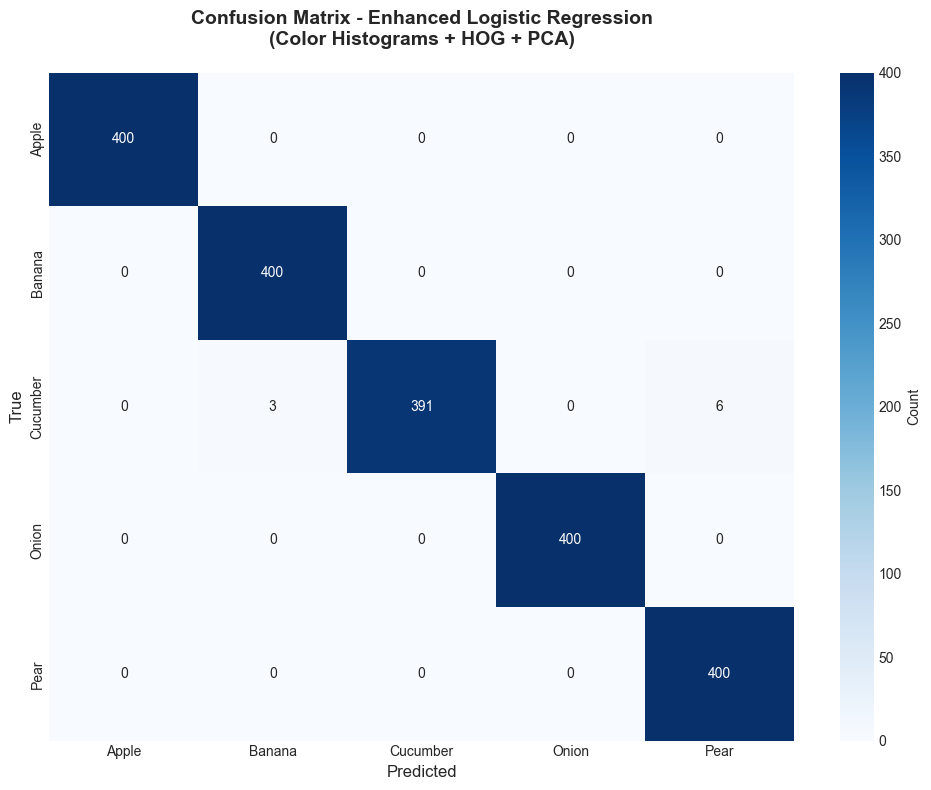

In [16]:
plt.figure(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=CLASSES, 
    yticklabels=CLASSES,
    cbar_kws={'label': 'Count'}
)

plt.title(
    'Confusion Matrix - Enhanced Logistic Regression\n'
    '(Color Histograms + HOG + PCA)', 
    fontsize=14, 
    fontweight='bold',
    pad=20
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.tight_layout()
plt.show()

### 9.2 ROC Curves

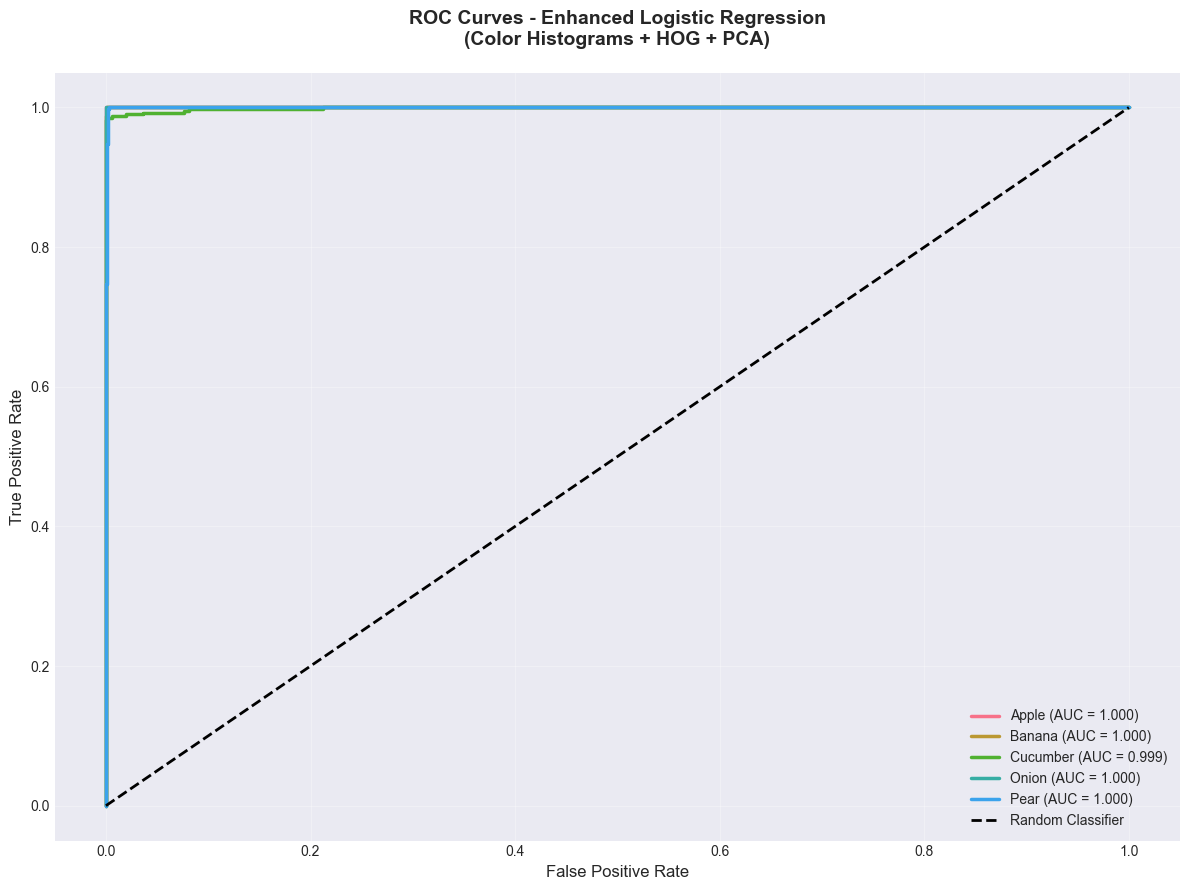

In [17]:
plt.figure(figsize=(12, 9))

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr, tpr, 
        linewidth=2.5, 
        label=f'{CLASSES[i]} (AUC = {roc_auc:.3f})'
    )

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

plt.title(
    'ROC Curves - Enhanced Logistic Regression\n'
    '(Color Histograms + HOG + PCA)', 
    fontsize=14, 
    fontweight='bold',
    pad=20
)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()